<a href="https://colab.research.google.com/github/dat810/tt2_things/blob/main/present_panic/present_panic_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating Games of Present Panic
This notebook simulates games of Present Panic in Tap Titans 2. It starts with simulations of a single board, later extending into simulating all levels set in the CSV file with a preset number of scissors.

[Skip to the Playground](#playground)

## Import Libraries

In [ ]:
import random
import numpy as np
import ctypes
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing as mp

## Load the CSV File
The file `HolidayEventBombGameLevelInfo.csv` contains all the boards for this event, as of version 7.5.0.

In [ ]:
level_info = pd.read_csv('HolidayEventBombGameLevelInfo.csv')
# level_info[level_info['ChestIconIndex'] == 2]
level_info.head(5)

,BoardNumber,BoardSize,Rows,Columns,SuccessesOnBoard,BombsOnBoard,SuccessesNeededToWin,RewardString,ChestIconIndex
0,0,9,3,3,8,1,3,"HolidayCurrency:3,Equipment:3",0
1,1,9,3,3,8,1,3,"HolidayCurrency:3,HelperWeapon:1",0
2,2,9,3,3,8,1,3,"HolidayCurrency:3,Diamonds:10",0
3,3,9,3,3,8,1,3,"HolidayCurrency:3,RaidCard:5",0
4,4,16,4,4,12,4,3,"HolidayCurrency:6,Equipment:Weapon_Nutcracker",1


## Set up a Class that Defines a Board

In [ ]:
class Board:
    def __init__(self,dim,trolls,target,diff_idx):
        self.dim = dim
        self.trolls = trolls
        self.target = target
        self.presents = self.dim[0]*self.dim[1]

        idx_to_diff = {
            0: 'Easy', 1: 'Hard', 2: 'Impossible'
        }
        self.diff = idx_to_diff.get(diff_idx)


    def __str__(self):
        return (
            f"Board size: {self.dim[0]}x{self.dim[1]}\n"
            f"Trolls count: {self.trolls}\n"
            f"Streak needed: {self.target}\n"
            f"Difficulty: {self.diff}"
        )

In [ ]:
b = Board([3,3], 1, 3, 0)
print(b)

Board size: 3x3
Trolls count: 1
Streak needed: 3
Difficulty: Easy


Start with a basic implementation of a simulation of a board in Python.

In [ ]:
def present_panic_sim_v1(p, t, target):
    '''
    Simulate a board in Present Panic.

    Parameters
    --
    p : int
        number of presents
    t : int
        number of trolls
    target : int
        correct presents to open

    Returns
    --
    int
        scissors needed to finish the board
    '''
    g = p - t
    total_scissors = 0
    streak = 0
    board = ['troll']*t + ['ginger']*g
    random.shuffle(board)

    while streak < target:
        draw = random.choice(board)
        total_scissors += 1

        if draw == 'ginger':
            streak += 1
            board.remove('ginger')
        else:
            streak = 0
            t -= 1
            board = ['troll']*t + ['ginger']*g
            random.shuffle(board)

    return total_scissors

In [ ]:
present_panic_sim_v1(12, 2, 3)

3

Since multiple simulations can take up lots of time, below is the above simulation's C equivalent.

In [ ]:
%%writefile present_panic_sim.c
#include <stdlib.h>
#include <time.h>

int present_panic_sim (int p, int t, int target) {
    int g = p - t;
    int total_scissors = 0;
    int streak = 0;
    int *board = (int *)malloc(p*sizeof(int));
    int i;

    // Initialize the board: 0 for trolls, 1 for ginger
    for (i=0;i<t;i++) {
        board[i] = 0; // troll
    }
    for (i=t;i<p;i++) {
        board[i] = 1; // ginger
    }

    srand((unsigned int)time(NULL)+rand());

    while (streak < target) {
        int index = rand() % p;
        total_scissors++;

        if (board[index] == 1) { // ginger
            streak++;
            board[index] = board[--p]; // Remove ginger and shrink board
        } else { // troll
            streak = 0;
            t--;
            p = t + g; // Reset board
            for (i = 0; i < t; i++) board[i] = 0; // troll
            for (i = t; i < p; i++) board[i] = 1; // ginger
        }
    }

    free(board);
    return total_scissors;
}

Writing present_panic_sim.c


In [ ]:
!gcc -shared -o present_panic_sim.so -fPIC present_panic_sim.c

Integrate the function using `ctypes` so that it can be used in a Python environment.

In [ ]:
# Load the compiled C shared library
lib = ctypes.CDLL('./present_panic_sim.so')

# Define the argument and return types
lib.present_panic_sim.argtypes = [ctypes.c_int, ctypes.c_int, ctypes.c_int]
lib.present_panic_sim.restype = ctypes.c_int

def present_panic_sim_c(p,t,target):
    """
    Wrapper for the C implementation of Present Panic simulation.
    Simulates a board in Present Panic.

    Parameters
    --
    p : int
        number of presents
    t : int
        number of trolls
    target : int
        correct presents to open

    Returns
    --
    int
        scissors needed to finish the board
    """
    return lib.present_panic_sim(p,t,target)

In [ ]:
present_panic_sim_c(12,2,3)

3

Writing the simulator for one single board. The outer function is in Python to run the simulation, while each individual simulation is run in C for performance.

In [ ]:
def present_panic_sim_runner(n,p,t,target):
    results = np.zeros(n)
    for i in range(n):
        results[i] = present_panic_sim_c(p,t,target)
    return results

## Open these Presents!
Start with a simulation for an easy board.

In [ ]:
n = 1000000
# Set up some sample boards. All are the first occurences of their respective difficulty.
easy = Board([3,3], 1, 3, 0)
hard = Board([4,4], 4, 3, 1)
impossible = Board([5,5], 6, 4, 2)

sim1 = present_panic_sim_runner(n,easy.presents,easy.trolls,easy.target)

unique, counts = np.unique(sim1, return_counts=True)
summary1 = dict(zip(unique, counts))
df1 = pd.Series(summary1)
df1

,0
3.0,667032
4.0,111814
5.0,111231
6.0,109923


Plot the results.

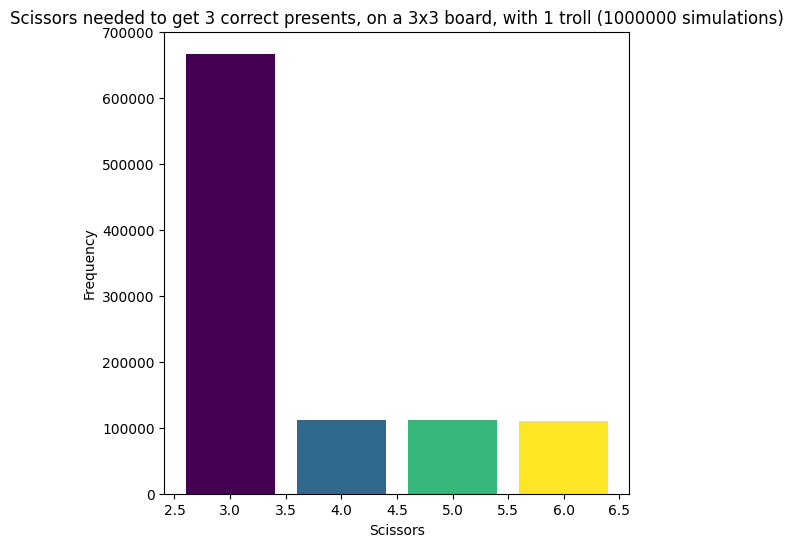

In [ ]:
# Normalize the categorical numbers to map them to a colormap
norm = plt.Normalize(min(unique), max(unique))  # Normalize to colormap range
colormap = plt.cm.viridis  # Choose a colormap

# Assign colors based on the normalized categories
colors = colormap(norm(unique))

plt.figure(figsize=(6,6))
# ax1 = plt.hist(sim1)
ax1 = plt.bar(unique, height=counts, color=colors)
plt.title(
    f"Scissors needed to get {easy.target} correct presents, on a "
    f"{easy.dim[0]}x{easy.dim[1]} board, with {easy.trolls} troll"
    f"{'' if easy.trolls == 1 else 's'} "
    f"({n} simulations)"
)
plt.xlabel('Scissors')
plt.ylabel('Frequency')
plt.show()

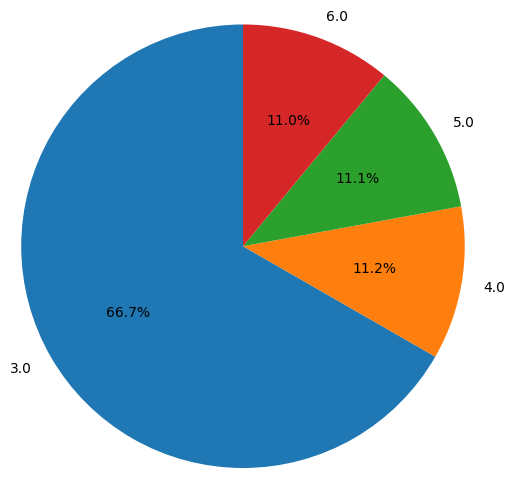

In [ ]:
plt.pie(counts, labels=unique, autopct='%1.1f%%', startangle=90, radius=1.5)
plt.show()

Similar thing for the hard board.

In [ ]:
sim2 = present_panic_sim_runner(n,hard.presents,hard.trolls,hard.target)

unique, counts = np.unique(sim2, return_counts=True)
summary2 = dict(zip(unique, counts))
df2 = pd.Series(summary2)
df2

,0
3.0,393445
4.0,121533
5.0,126494
6.0,130717
7.0,76028
8.0,61743
9.0,42411
10.0,22531
11.0,13764
12.0,7283


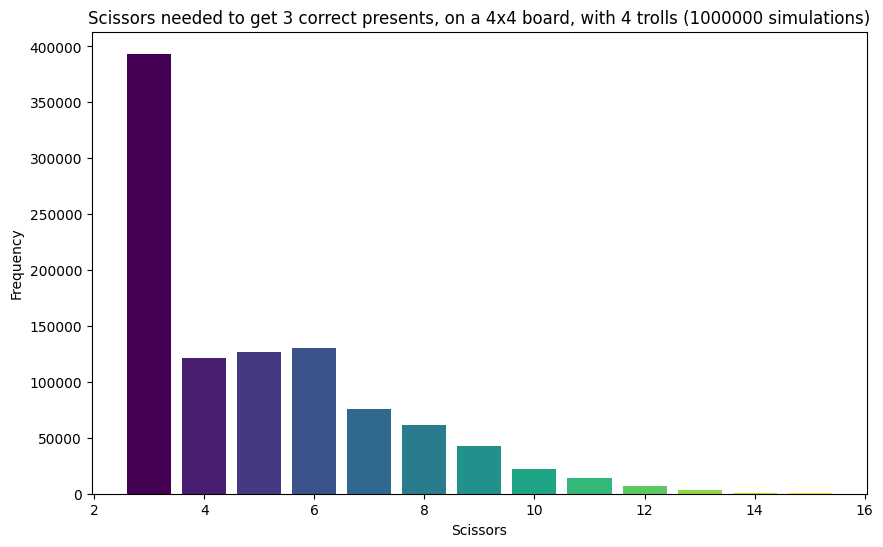

In [ ]:
norm = plt.Normalize(min(unique), max(unique))
colormap = plt.cm.viridis

colors = colormap(norm(unique))

plt.figure(figsize=(10,6))
ax1 = plt.bar(unique, height=counts, color=colors)
plt.title(
    f"Scissors needed to get {hard.target} correct presents, on a "
    f"{hard.dim[0]}x{hard.dim[1]} board, with {hard.trolls} troll"
    f"{'' if hard.trolls == 1 else 's'} "
    f"({n} simulations)"
)
plt.xlabel('Scissors')
plt.ylabel('Frequency')
plt.show()

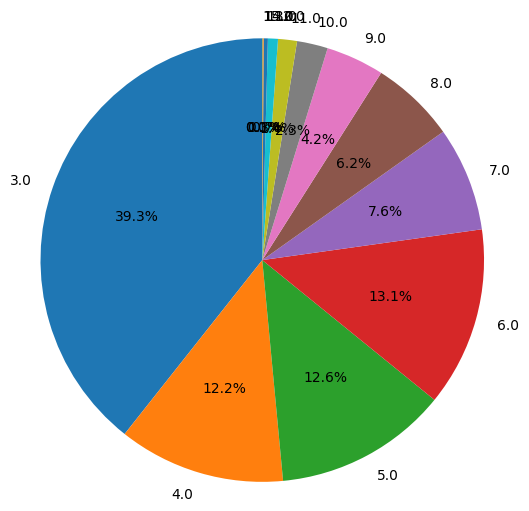

In [ ]:
plt.pie(counts, labels=unique, autopct='%1.1f%%', startangle=90, radius=1.5)
plt.show()

## Simulating the Entire Event
Now time to simulate the whole event. First, the CSV file is parsed to only include relevant columns.

In [ ]:
parsed = level_info[['Rows', 'Columns', 'BombsOnBoard', 'SuccessesNeededToWin', 'ChestIconIndex']]
parsed.head(5)

,Rows,Columns,BombsOnBoard,SuccessesNeededToWin,ChestIconIndex
0,3,3,1,3,0
1,3,3,1,3,0
2,3,3,1,3,0
3,3,3,1,3,0
4,4,4,4,3,1


Next, the boards are set up.

In [ ]:
boards = []
for row in parsed.itertuples(index=False):
    boards.append(Board([row[0],row[1]],row[2],row[3],row[4]))
# boards[500].target

The event simulator function itself.

In [ ]:
def event_sim(n, start):
    results = np.zeros(n)
    for j in range(n):
        i = 0
        scissors = start
        while scissors > 0:
            p = boards[i].presents
            t = boards[i].trolls
            target = boards[i].target

            scissors_used = present_panic_sim_c(p,t,target)
            scissors -= scissors_used

            if scissors > 0:
                i += 1
        results[j] = i
    return results

Time to simulate! The scissor count is assuming if a player does 99 prestiges for all 21 days, without buying additional bundles.

In [ ]:
scis_count = 99*21*3
n = 100000
e1 = event_sim(n, scis_count)

unique, counts = np.unique(e1, return_counts=True)
e_summary1 = dict(zip(unique, counts))
df3 = pd.Series(e_summary1)
df3

,0
409.0,1
411.0,1
412.0,9
413.0,22
414.0,32
415.0,68
416.0,438
417.0,525
418.0,919
419.0,1359


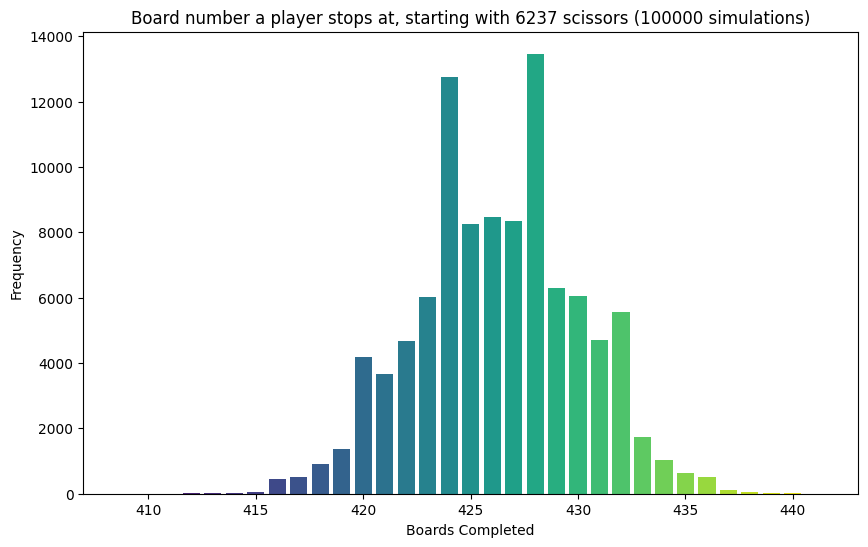

In [ ]:
norm = plt.Normalize(min(unique), max(unique))
colormap = plt.cm.viridis
colors = colormap(norm(unique))

plt.figure(figsize=(10,6))
ax1 = plt.bar(unique, height=counts, color=colors)
plt.title(
    f"Board number a player stops at, "
    f"starting with {scis_count} scissor{'' if scis_count == 1 else 's'} "
    f"({n} simulations)"
)
plt.xlabel('Boards Completed')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print(boards[428])

Board size: 6x6
Trolls count: 13
Streak needed: 11
Difficulty: Hard


## Playground
Choose a level you are currently on and see its average scissor cost!

Board size: 6x4
Trolls count: 6
Streak needed: 7
Difficulty: Easy


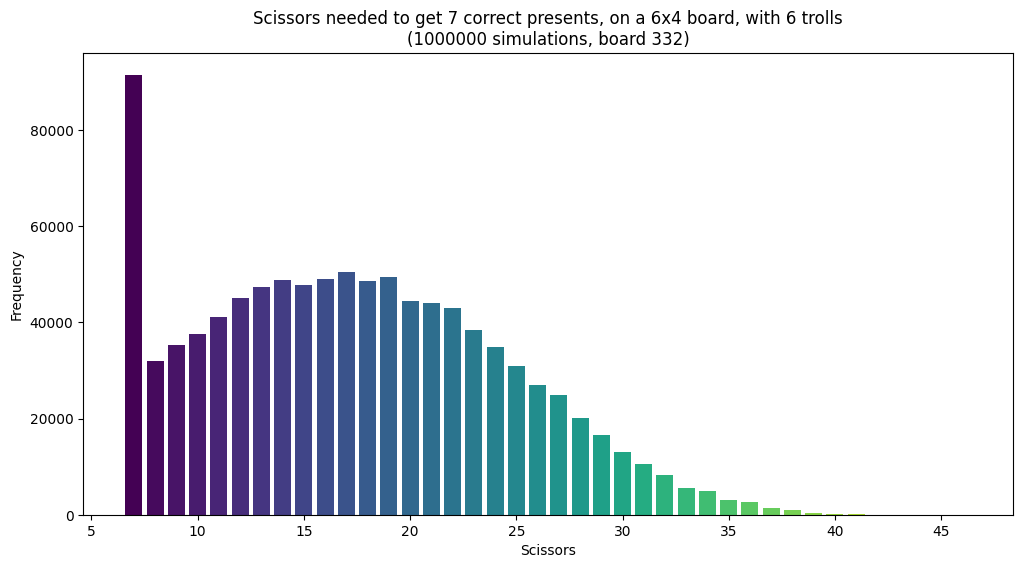

In [ ]:
my_idx = 332 # Edit here
my_board = boards[my_idx-1]
print(my_board)
n = 1000000
my_sim = present_panic_sim_runner(n,my_board.presents,my_board.trolls,my_board.target)
unique, counts = np.unique(my_sim, return_counts=True)

norm = plt.Normalize(min(unique), max(unique))
colormap = plt.cm.viridis
colors = colormap(norm(unique))
plt.figure(figsize=(12,6))
my_ax = plt.bar(unique, height=counts, color=colors)
plt.title(
    f"Scissors needed to get {my_board.target} correct presents, on a "
    f"{my_board.dim[0]}x{my_board.dim[1]} board, with {my_board.trolls} troll"
    f"{'' if my_board.trolls == 1 else 's'}\n"
    f"({n} simulations, board {my_idx})"
)
plt.xlabel('Scissors')
plt.ylabel('Frequency')
plt.show()